In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
fer_directory = 'data/FER2013'
ck_directory = 'data/CK+'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.10.1
Num GPUs Available:  1


In [9]:
# Initialise generator with rescale factor 1./255
train_gen = ImageDataGenerator(rescale=1./255, rotation_range=10,  zoom_range=0.1, horizontal_flip=True, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, horizontal_flip=True)

# Preprocess training set
train_generator = train_gen.flow_from_directory(
    fer_directory + '/train',
    target_size=(48,48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_gen.flow_from_directory(
    fer_directory + '/train',
    target_size=(48,48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Preprocess test set
test_generator = test_gen.flow_from_directory(
    fer_directory + '/test',
    target_size=(48,48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [10]:
# Define model
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd convolution layer
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3rd convolution layer
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten and feed into dense layer
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(7, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_5 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)      

In [11]:
# Plots image
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
# Image('model.png',width=400, height=200)

In [12]:
# Train model
epochs = 40
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')

# Stop training when val loss has stopped improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save model weights
checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)

# Train model
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, reduce_lr, early_stop, PlotLossesKeras()],
)

Epoch 1/40
 77/358 [=====>........................] - ETA: 21s - loss: 2.1387 - accuracy: 0.2234

KeyboardInterrupt: 

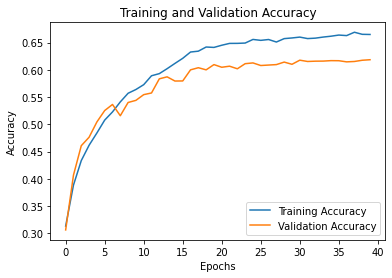

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(0)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Accuracy.png')
plt.show()

In [13]:
# Reference model
ref_model = Sequential()

ref_model.add(Conv2D(256, (3,3), padding='same', input_shape=(48,48,1), activation='relu'))
ref_model.add(Conv2D(516, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Conv2D(384, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Conv2D(192, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Conv2D(384, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Flatten())
ref_model.add(Dense(256, activation='relu'))
ref_model.add(BatchNormalization())

ref_model.add(Dropout(0.3))
ref_model.add(Dense(7, activation='softmax'))

ref_model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
ref_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 256)       2560      
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 516)       1189380   
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 516)      2064      
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 516)      0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 24, 24, 516)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 384)      

In [16]:
# Train model
epochs = 40
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')

# Stop training when val loss has stopped improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# Save model weights
checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=2)

# Train model
history = ref_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, reduce_lr, early_stop, PlotLossesKeras()],
)

Epoch 1/40
230/358 [==================>...........] - ETA: 1:26 - loss: 2.3749 - accuracy: 0.2000